In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../../lab_1/')

from functions import (
    get_random_portfolios,
    get_VaR,
    solve_markowitz,
)

import financedatabase as fd

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.simplefilter(action='ignore', category=RuntimeWarning)

PATH_TO_DATA = "../../lab_1/data/data_with_return.csv"

In [2]:
import pickle
with open("../temp_data/top10.pickle", 'rb') as f:
    top10 = pickle.load(f)

In [3]:
TOKEN = "yfj4hxcXAyB6RdR3NuQcI0NhJD6fqTW6"
NUM_STOCKS = 10

equities = fd.Equities().search(exchange="MCX")
equities = equities.rename(index=lambda s: s[:-3])
equities = equities[["name", "sector"]]

df = pd.read_csv(PATH_TO_DATA, encoding='UTF-16')
df = df.set_index('SECID').loc[top10].join(equities, how="left")
df = df.drop(set(df[df.name.isna()].index))

df["SECID"] = df.index
df = df.reset_index(drop=True)

new_df = dict()
for stock in df["SECID"].unique():
    stock_returns = df[df["SECID"] == stock].sort_values(by="TRADEDATE")["RETURN"].to_list()
    new_df[stock] = stock_returns
new_df = pd.DataFrame(new_df)
new_df = new_df.sort_index(axis=1)
new_df

,AGRO,AKRN,LKOH,NKNCP,NVTK,ROSN,SIBN,SNGSP,TATN,TATNP
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.008811,0.015402,0.022970,-0.005296,0.003160,0.029922,0.004936,-0.001929,0.030747,0.002716
2,-0.004435,-0.001505,0.019377,0.001768,0.005292,0.015995,0.002050,-0.000351,-0.002194,0.008373
3,0.007086,-0.000753,0.016394,0.000000,-0.008021,0.010047,0.019867,0.004205,0.020550,0.022341
4,0.006159,0.003259,0.003439,-0.003540,-0.014485,0.008375,0.015535,0.000874,-0.001958,0.004723
...,...,...,...,...,...,...,...,...,...,...
249,-0.039221,0.002200,-0.020373,-0.003873,-0.020837,-0.012151,-0.011034,0.002845,-0.008858,-0.011376
250,0.003328,0.006572,0.004046,0.021754,0.008150,0.013358,0.022504,0.001935,0.021579,0.037630
251,0.046097,0.007830,0.011222,0.012579,0.008988,0.014372,-0.044073,0.005141,0.006998,0.011966
252,0.008215,-0.003472,0.014534,0.000000,0.018270,0.012877,0.000291,-0.002182,0.028597,0.029011


### Короткие продажи запрещены

In [8]:
w = solve_markowitz(new_df)
display(w.T)

,AGRO,AKRN,LKOH,NKNCP,NVTK,ROSN,SIBN,SNGSP,TATN,TATNP
weights,0.201479,0.142026,0.0,0.21493,0.12262,0.035439,0.087465,0.066603,0.040556,0.088882


In [9]:
portfolio_return = sum(new_df.mean() * w.weights)
portfolio_risk = np.sqrt(w.weights @ new_df.cov().values @ w.weights.T)

In [10]:
NUM_RANDOM_PORTFOLIO = 100
SEED = 18
N = df.SECID.nunique()
np.random.seed(SEED)
random_portfolio_df = get_random_portfolios(df, random_samples=NUM_RANDOM_PORTFOLIO)

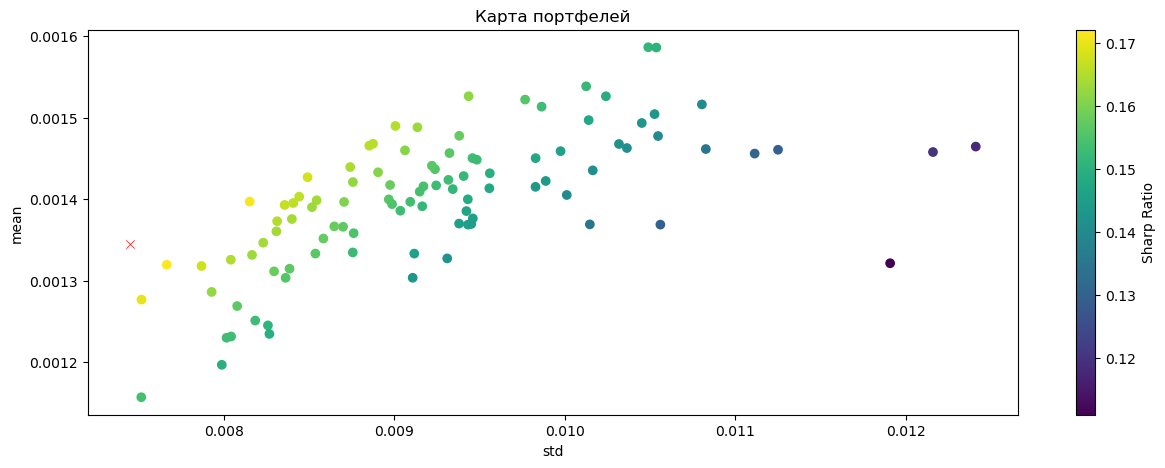

In [11]:
# ratios = (new_df.mean() - risk_free) / new_df.std()
ratios = (random_portfolio_df["mean"] / random_portfolio_df["std"])

plt.figure(figsize=(15, 5))
sc = plt.scatter(data=random_portfolio_df, x="std", y="mean", c=ratios)
sns.scatterplot(x=[portfolio_risk], y=[portfolio_return], c="r", marker="x");

plt.colorbar(sc, label="Sharp Ratio");
plt.ylabel("mean")
plt.xlabel("std")
plt.title("Карта портфелей")
plt.legend('', frameon=False);

Опять построим несколько рандомных портфелей. Конечно, наш оптимальный портфель оказался лучше и по риску и по доходу. Его sharp ratio: 0.1815.

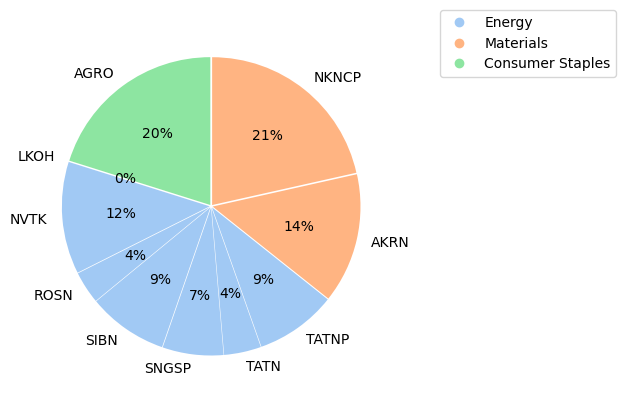

In [12]:
all_stocks = w.join(equities, how="left")
sectors = all_stocks["sector"].values

colors = sns.color_palette('pastel')[0:len(sectors)]
colors_dict = dict()
for i, sector in enumerate(set(sectors)):
    colors_dict[sector] = colors[i]

plt.pie(
    all_stocks.sort_values(by="sector").weights,
    labels = all_stocks.sort_values(by="sector").index, 
    colors = all_stocks.sort_values(by="sector")["sector"].map(colors_dict), 
    autopct='%.0f%%',
    startangle=90, 
    explode=[0.01] * len(sectors)
    )

# The following two lines generate custom fake lines that will be used as legend entries:
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors_dict.values()]
plt.legend(markers, colors_dict.keys(), numpoints=1, bbox_to_anchor=(1.1, 1.05))
plt.show()

Можно для себя на будущее отметить, что лукойл не получил долю при распределении. 

In [13]:
stocks_expected_return = df.groupby(by="SECID").agg({"RETURN": "mean"}).sort_index()
gamma = 0.9
VaR = get_VaR(new_df.mean() * w.weights, gamma)
print(f"Возможные потери:{VaR:0.10f}")

Возможные потери:-0.0000467944


### Короткие продажи разрешены

In [20]:
w_short = solve_markowitz(new_df, with_short=True)
portfolio_return_short = sum(new_df.mean() * w_short.weights)
portfolio_risk_short = np.sqrt(w_short.weights @ new_df.cov().values @ w_short.weights.T)

display(w_short.T)

,AGRO,AKRN,LKOH,NKNCP,NVTK,ROSN,SIBN,SNGSP,TATN,TATNP
weights,0.209409,0.155797,-0.069671,0.211534,0.125561,0.053796,0.089291,0.062744,0.073487,0.088052


In [24]:
print("Напомним себе, как выглядили доли с запретом коротких продаж")
display(w.T)

Напомним себе, как выглядили доли с запретом коротких продаж


,AGRO,AKRN,LKOH,NKNCP,NVTK,ROSN,SIBN,SNGSP,TATN,TATNP
weights,0.201479,0.142026,0.0,0.21493,0.12262,0.035439,0.087465,0.066603,0.040556,0.088882


Т.е. если при запрете коротких продаж у Лукойла доли не было, то при разрешении мы сразу это используем.  

In [18]:
NUM_RANDOM_PORTFOLIO = 100
SEED = 18
N = df.SECID.nunique()
np.random.seed(SEED)
random_portfolio_df = get_random_portfolios(df, random_samples=NUM_RANDOM_PORTFOLIO, with_short=True)

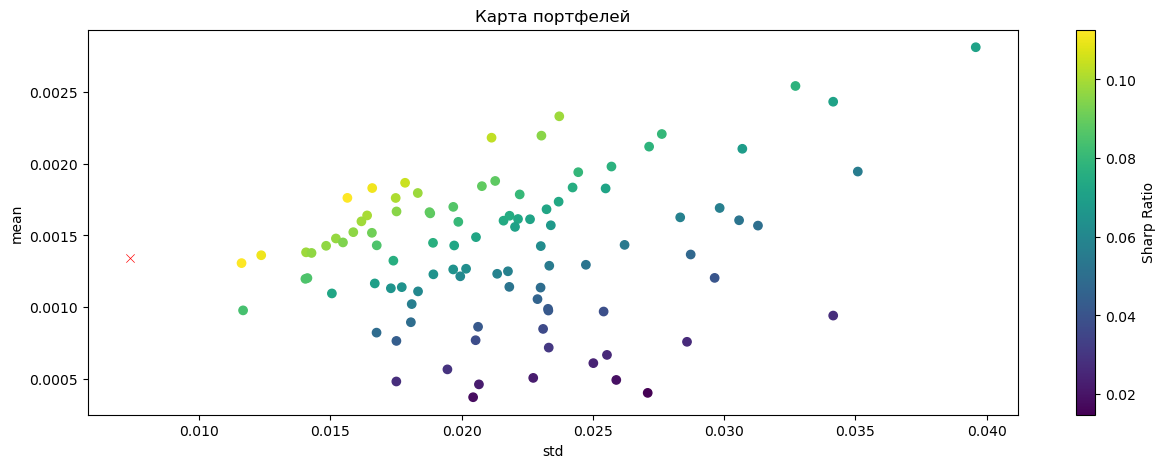

In [21]:
ratios = (random_portfolio_df["mean"] / random_portfolio_df["std"])

plt.figure(figsize=(15, 5))
sc = plt.scatter(data=random_portfolio_df, x="std", y="mean", c=ratios)
sns.scatterplot(x=[portfolio_risk_short], y=[portfolio_return_short], c="r", marker="x");

plt.colorbar(sc, label="Sharp Ratio");
plt.ylabel("mean")
plt.xlabel("std")
plt.title("Карта портфелей")
plt.legend('', frameon=False);

И опять оптимальный портфель оказался лучше. Его sharp ratio примерно такое же, как и при запрете коротких продаж, т.к. на самом деле кардинальных различий в долях нет. Только засчет игры в короткую на Лукойле небольшой прирост, который можно увидеть через VaR. 

In [22]:
stocks_expected_return = df.groupby(by="SECID").agg({"RETURN": "mean"}).sort_index()
gamma = 0.9
VaR = get_VaR(new_df.mean() * w_short.weights, gamma)
print(f"Возможные потери:{VaR:0.10f}")

Возможные потери:-0.0000606445
